In [1]:
%%capture
import os
import pandas as pd
import numpy as np
import mne
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy.signal import welch

In [2]:
%%capture
# Define a function to extract labels from filenames
def extract_label_from_filename(filename):
    # Assuming filenames are in the format: subject_task.bdf
    task = filename.split('_')[1].split('.')[0].split('-')[1]
    return task

In [3]:
%%capture
#Convert to DataFrame
def convert_bdf_to_dataframe(bdf_filename):
    raw_data = mne.io.read_raw_bdf(bdf_filename, preload=True)
    eeg_data_raw = raw_data.get_data()
    channel_names = raw_data.ch_names
    time_index = raw_data.times
    eeg_data = pd.DataFrame(data=eeg_data_raw.T, columns=channel_names, index=time_index)
    col_names = ['O1', 'O2', 'F3', 'F4', 'C3' ,'C4' , 'Fp1', 'Fp2']
    eeg_data = eeg_data[col_names]
    segment_size = 1024
    num_segments = len(eeg_data) // segment_size
    reduced_df = pd.DataFrame(columns=eeg_data.columns)
    for i in range(num_segments):
        start_idx = i * segment_size
        end_idx = (i + 1) * segment_size
        segment_data = eeg_data.iloc[start_idx:end_idx]    
        mean_values = segment_data.mean()
        reduced_df = reduced_df.append(mean_values, ignore_index=True)

    return reduced_df, raw_data

In [4]:
req_cols = ['F3', 'F4', 'C3' ,'C4' , 'Fp1', 'Fp2', 'O1', 'O2']
main_df_cols = []

for col in req_cols:
    if col == 'O1' or col == 'O2':
        main_df_cols.append(f'{col} gamma mean')
        main_df_cols.append(f'{col} gamma psd_mean')
    else:
        main_df_cols.append(f'{col} alpha mean')
        main_df_cols.append(f'{col} alpha psd_mean')
        main_df_cols.append(f'{col} beta mean')
        main_df_cols.append(f'{col} beta psd_mean')
main_df_cols.append('task')
        
main_df = pd.DataFrame(columns=main_df_cols)

In [5]:
main_df

,F3 alpha mean,F3 alpha psd_mean,F3 beta mean,F3 beta psd_mean,F4 alpha mean,F4 alpha psd_mean,F4 beta mean,F4 beta psd_mean,C3 alpha mean,C3 alpha psd_mean,...,Fp1 beta psd_mean,Fp2 alpha mean,Fp2 alpha psd_mean,Fp2 beta mean,Fp2 beta psd_mean,O1 gamma mean,O1 gamma psd_mean,O2 gamma mean,O2 gamma psd_mean,task


In [5]:
def extract_mean_and_psd_mean(reduced_decomp_df, label):
    values = []
    req_channels = reduced_decomp_df.columns
    for channel in req_channels:
        mean_val = reduced_decomp_df[channel].mean()
        _, psd = welch(reduced_decomp_df[channel], fs=256)
        values.append(mean_val)
        values.append(psd.mean())
    values.append(label)
    main_df.loc[main_df.shape[0]] = values

In [6]:
data_dir1 = './Dataset - 3/'# Replace with the path to your .bdf data directory
data_dir2 = './Dataset-2'

In [7]:
%%capture

# Initialize empty lists to store data and labels
data = []
labels = []
raw_eegdata = []

# Loop through all files in the directory
for filename in os.listdir(data_dir1):
    if filename.endswith('.bdf'):
        # Convert the .bdf file to a DataFrame
        eeg_data, eeg_raw = convert_bdf_to_dataframe(os.path.join(data_dir1, filename))
        
        # Extract labels from filenames
        label = extract_label_from_filename(filename)
#         # Append data and labels
        raw_eegdata.append(eeg_raw)
    
        channel_name_1 = ['O1', 'O2']
        channel_name_2 = ['F3', 'F4','C3' ,'C4' , 'Fp1', 'Fp2']  # Add more channel names as needed

#         # Create dictionaries to store the filtered data
        eeg_dataframe = pd.DataFrame()


        # Loop through each channel and filter data
        for channel_name in channel_name_2:
            eeg_channel = eeg_raw.copy().pick_channels([channel_name])
    
            # Filter for Alpha (8-13 Hz)
            alpha_filtered = eeg_channel.filter(l_freq=8, h_freq=13)
            alpha_decomp = alpha_filtered.get_data()[0]
            eeg_dataframe[f'{channel_name} alpha'] = alpha_decomp
    
            # Filter for Beta (13-30 Hz)
            beta_filtered = eeg_channel.filter(l_freq=13, h_freq=30)
            beta_decomp = beta_filtered.get_data()[0]
            eeg_dataframe[f'{channel_name} beta'] = beta_decomp
    
        for channel_name in channel_name_1:
            eeg_channel = eeg_raw.copy().pick_channels([channel_name])
    
            # Filter for Gamma (30-40 Hz)
            gamma_filtered = eeg_channel.filter(l_freq=30, h_freq=40)
            gamma_decomp = gamma_filtered.get_data()[0]
            eeg_dataframe[f'{channel_name} gamma'] = gamma_decomp

        # Grouping data for each second
        segment_size = 1024
        num_segments = len(eeg_dataframe) // segment_size
        reduced_decomp_df = pd.DataFrame(columns=eeg_dataframe.columns)
        for i in range(num_segments):
            start_idx = i * segment_size
            end_idx = (i + 1) * segment_size
            segment_data = eeg_dataframe.iloc[start_idx:end_idx]    
            mean_values = segment_data.mean()
            sampling_frequency = 1024  
            reduced_decomp_df = reduced_decomp_df.append(mean_values, ignore_index=True)
        
        extract_mean_and_psd_mean(reduced_decomp_df, label)

In [8]:
main_df.to_csv('main_df3.csv')

In [9]:
%%capture

# Initialize empty lists to store data and labels
data = []
labels = []
raw_eegdata = []

for filename in os.listdir(data_dir2):
    if filename.endswith('.bdf'):
        # Convert the .bdf file to a DataFrame
        eeg_data, eeg_raw = convert_bdf_to_dataframe(os.path.join(data_dir2, filename))
        
        # Extract labels from filenames
        label = extract_label_from_filename(filename)
#         # Append data and labels
        raw_eegdata.append(eeg_raw)
    
        channel_name_1 = ['O1', 'O2']
        channel_name_2 = ['F3', 'F4','C3' ,'C4' , 'Fp1', 'Fp2']  # Add more channel names as needed

#         # Create dictionaries to store the filtered data
        eeg_dataframe = pd.DataFrame()


        # Loop through each channel and filter data
        for channel_name in channel_name_2:
            eeg_channel = eeg_raw.copy().pick_channels([channel_name])
    
            # Filter for Alpha (8-13 Hz)
            alpha_filtered = eeg_channel.filter(l_freq=8, h_freq=13)
            alpha_decomp = alpha_filtered.get_data()[0]
            eeg_dataframe[f'{channel_name} alpha'] = alpha_decomp
    
            # Filter for Beta (13-30 Hz)
            beta_filtered = eeg_channel.filter(l_freq=13, h_freq=30)
            beta_decomp = beta_filtered.get_data()[0]
            eeg_dataframe[f'{channel_name} beta'] = beta_decomp
    
        for channel_name in channel_name_1:
            eeg_channel = eeg_raw.copy().pick_channels([channel_name])
    
            # Filter for Gamma (30-40 Hz)
            gamma_filtered = eeg_channel.filter(l_freq=30, h_freq=40)
            gamma_decomp = gamma_filtered.get_data()[0]
            eeg_dataframe[f'{channel_name} gamma'] = gamma_decomp

        # Grouping data for each second
        segment_size = 1024
        num_segments = len(eeg_dataframe) // segment_size
        reduced_decomp_df = pd.DataFrame(columns=eeg_dataframe.columns)
        for i in range(num_segments):
            start_idx = i * segment_size
            end_idx = (i + 1) * segment_size
            segment_data = eeg_dataframe.iloc[start_idx:end_idx]    
            mean_values = segment_data.mean()
            sampling_frequency = 1024  
            reduced_decomp_df = reduced_decomp_df.append(mean_values, ignore_index=True)
        
        extract_mean_and_psd_mean(reduced_decomp_df, label)

In [10]:
main_df.to_csv('main_df1.csv')

In [9]:
df1 = pd.read_csv('main_df3.csv')

# Load the second CSV file into another DataFrame
df2 = pd.read_csv('merged_dataset.csv')

# Append df2 to df1
merged_df = pd.concat([df1, df2], ignore_index=True)

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('merged_dataset_final.csv', index=False)

In [10]:
main_df = pd.read_csv('merged_dataset_final.csv')


In [12]:
main_df.drop('Unnamed: 0', axis = 1, inplace = True)

In [13]:
main_df

,F3 alpha mean,F3 alpha psd_mean,F3 beta mean,F3 beta psd_mean,F4 alpha mean,F4 alpha psd_mean,F4 beta mean,F4 beta psd_mean,C3 alpha mean,C3 alpha psd_mean,...,Fp1 beta psd_mean,Fp2 alpha mean,Fp2 alpha psd_mean,Fp2 beta mean,Fp2 beta psd_mean,O1 gamma mean,O1 gamma psd_mean,O2 gamma mean,O2 gamma psd_mean,task
0,-4.867962e-10,1.863903e-16,5.105205e-11,1.308141e-17,-4.054061e-10,1.612327e-16,2.408305e-11,1.270943e-17,-4.467725e-10,7.284633e-17,...,4.429564e-21,-3.974103e-10,1.872751e-16,1.636326e-11,1.110764e-17,3.294602e-11,5.996870e-19,2.374691e-11,3.133132e-19,med1breath
1,1.279596e-11,5.882620e-17,6.924805e-12,7.929442e-18,1.390942e-10,7.522367e-17,4.310108e-11,8.310610e-18,8.385765e-11,3.239659e-17,...,5.142336e-21,1.903506e-10,7.116940e-17,9.087192e-11,7.520859e-18,3.514684e-11,8.286854e-19,-4.087968e-12,3.840532e-19,med2
2,2.877480e-10,3.765389e-16,1.434395e-10,5.072572e-17,2.259609e-10,3.910511e-16,1.358532e-10,4.634563e-17,5.372879e-10,1.854070e-16,...,2.566219e-20,2.666475e-10,4.036656e-16,1.723738e-10,4.578741e-17,4.943890e-11,3.201481e-18,7.791576e-11,1.252259e-18,think1
3,3.430648e-11,7.242793e-16,-1.015631e-10,7.947596e-17,1.371661e-11,8.768814e-16,-1.139151e-10,9.139637e-17,7.512464e-11,2.776926e-16,...,2.667530e-20,-2.153132e-11,4.418735e-16,-7.115125e-11,4.709444e-17,-1.256236e-11,3.519316e-18,-1.604890e-11,1.177812e-18,think2
4,-1.544980e-10,7.981839e-16,-3.384425e-10,1.927796e-17,1.965323e-10,9.066192e-16,-2.911872e-10,2.184374e-17,6.562743e-11,3.962571e-16,...,4.709807e-21,1.656997e-10,9.955179e-16,-3.652033e-10,2.626207e-17,2.948619e-12,6.689475e-19,2.699047e-11,3.707095e-19,med1breath
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,-1.387821e-10,8.413695e-17,-1.256059e-10,9.725490e-18,-2.704213e-11,8.272582e-17,-1.301180e-10,8.603298e-18,-5.838569e-11,5.360316e-17,...,4.728084e-21,-6.295782e-11,9.772556e-17,-1.581227e-10,1.066868e-17,4.599238e-11,7.205702e-17,1.189598e-12,1.767439e-18,think2
388,-5.904289e-10,1.581792e-15,1.861273e-10,1.218747e-17,-4.818151e-10,1.687423e-15,1.456581e-10,1.381666e-17,-3.870716e-10,7.074346e-16,...,5.118837e-21,-3.838340e-10,1.778101e-15,2.113517e-10,1.304408e-17,-3.354180e-11,5.831825e-19,-3.003426e-11,6.146522e-19,med1breath
389,1.164268e-10,2.823474e-16,-2.635715e-10,2.292753e-17,1.151847e-10,2.992111e-16,-3.804364e-10,3.866174e-17,-6.357785e-12,1.071711e-16,...,4.989548e-21,5.790677e-11,3.290694e-16,-3.869340e-10,3.754514e-17,-4.131331e-11,4.771140e-19,-3.894485e-11,4.450681e-19,med2
390,-6.949902e-10,6.435969e-16,-1.958782e-10,1.352549e-17,-4.536244e-10,7.191354e-16,-1.531733e-10,1.342371e-17,-8.262109e-10,2.917959e-16,...,5.916592e-21,-5.405045e-10,6.984036e-16,-1.885073e-10,1.304629e-17,-1.816352e-10,5.996827e-19,-2.015333e-10,5.794415e-19,think1


In [76]:
X = main_df.drop('task', axis = 1)
y = main_df['task']

In [77]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


min_max_scaler = MinMaxScaler()
X_min = min_max_scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_labels = label_encoder.classes_

X_train, X_test, y_train, y_test = train_test_split(X_min, y_encoded, test_size=0.1, random_state=42)


In [78]:
from sklearn.linear_model import LogisticRegression
# Create a Random Forest classifier (you can try other classifiers as well)
clf = LogisticRegression(random_state=11)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.25

In [79]:
from sklearn.ensemble import AdaBoostClassifier

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)
model = AdaBoostClassifier()

model.fit(X_train,y_train)
preds = model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(accuracy)

0.25


In [80]:
from xgboost import XGBClassifier

# Standardize the features (optional but recommended)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = XGBClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.2222222222222222

In [83]:
import numpy as np
from sklearn.svm import SVC

# Create an SVM classifier
clf = SVC(kernel='linear', C=1.0)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the classifier's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.17


In [72]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Evaluate the classifier on the test data (optional)
accuracy = clf.score(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

# Get feature importances
feature_importances = clf.feature_importances_

# Print the importance of each feature
for feature, importance in zip(X.columns, feature_importances):
    print(f'{feature}: {importance:.4f}')

Accuracy: 0.21


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [84]:
import tensorflow as tf

# Define a neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(class_labels), activation='softmax')  # Output layer with softmax activation
])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Compile the model with categorical cross-entropy loss
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy
              metrics=['accuracy'])

# Convert target labels to one-hot encoding
y_train_one_hot = keras.utils.to_categorical(y_train, len(class_labels))
y_test_one_hot = keras.utils.to_categorical(y_test, len(class_labels))

# Train the model
model.fit(X_train, y_train_one_hot, epochs=100, batch_size=64, validation_split=0.2, callbacks=[callback])

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
print(f'Test accuracy: {test_acc:.4f}')

# Make predictions
predictions = model.predict(X_test)

# Convert predicted labels back to string labels
predicted_labels = [class_labels[np.argmax(pred)] for pred in predictions]
predicted_labels_encoded = label_encoder.transform(predicted_labels)


Epoch 1/100
4/4 [==============================] - 0s 26ms/step - loss: 1.4130 - accuracy: 0.2540 - val_loss: 1.3862 - val_accuracy: 0.1719
Epoch 2/100
4/4 [==============================] - 0s 4ms/step - loss: 1.3804 - accuracy: 0.2937 - val_loss: 1.3930 - val_accuracy: 0.2031
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 1.3600 - accuracy: 0.3413 - val_loss: 1.3969 - val_accuracy: 0.1875
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 1.3485 - accuracy: 0.3770 - val_loss: 1.3994 - val_accuracy: 0.2031
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 1.3377 - accuracy: 0.3929 - val_loss: 1.4029 - val_accuracy: 0.2188
Epoch 6/100
4/4 [==============================] - 0s 5ms/step - loss: 1.3280 - accuracy: 0.3929 - val_loss: 1.4014 - val_accuracy: 0.2031
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 1.3189 - accuracy: 0.4087 - val_loss: 1.4010 - val_accuracy: 0.2344
Epoch 8/100
4/4 [=========

In [53]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Assuming you have your data loaded as X_train, y_train, X_test, y_test
num_unique_values = X_train.shape[0]
input_sequence_length = 28
embedding_dim = 1
# Define the CNN model
model = keras.Sequential([
    layers.Embedding(input_dim=num_unique_values, output_dim=embedding_dim, input_length=input_sequence_length),
    layers.Conv1D(128, 5, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 5, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

# Make predictions
predictions = model.predict(X_test)


Epoch 1/100
7/7 [==============================] - 0s 18ms/step - loss: 1.3861 - accuracy: 0.2634 - val_loss: 1.3893 - val_accuracy: 0.2105
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: 1.3842 - accuracy: 0.2812 - val_loss: 1.3936 - val_accuracy: 0.2105
Epoch 3/100
7/7 [==============================] - 0s 4ms/step - loss: 1.3821 - accuracy: 0.2812 - val_loss: 1.3999 - val_accuracy: 0.2105
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 1.3807 - accuracy: 0.2812 - val_loss: 1.4093 - val_accuracy: 0.2105
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 1.3799 - accuracy: 0.2812 - val_loss: 1.4206 - val_accuracy: 0.2105
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 1.3798 - accuracy: 0.2812 - val_loss: 1.4181 - val_accuracy: 0.2105
Epoch 7/100
7/7 [==============================] - 0s 4ms/step - loss: 1.3800 - accuracy: 0.2812 - val_loss: 1.4161 - val_accuracy: 0.2105
Epoch 8/100
7/7 [=========

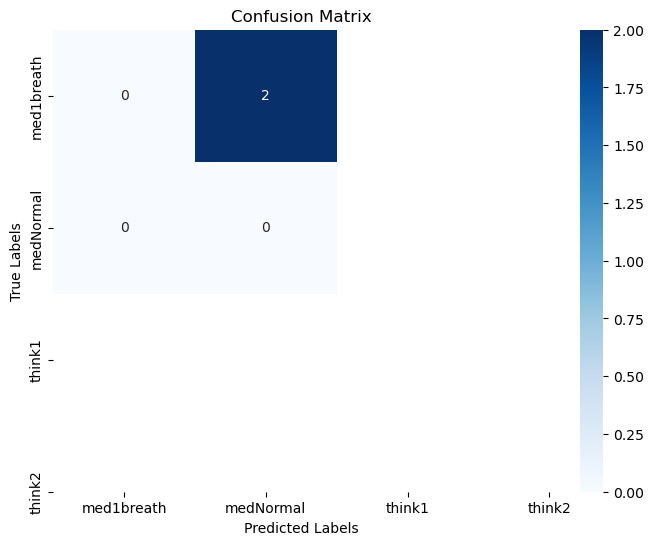

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test contains true labels and predicted_labels contains predicted labels
# These should be NumPy arrays or Python lists.

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels_encoded)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


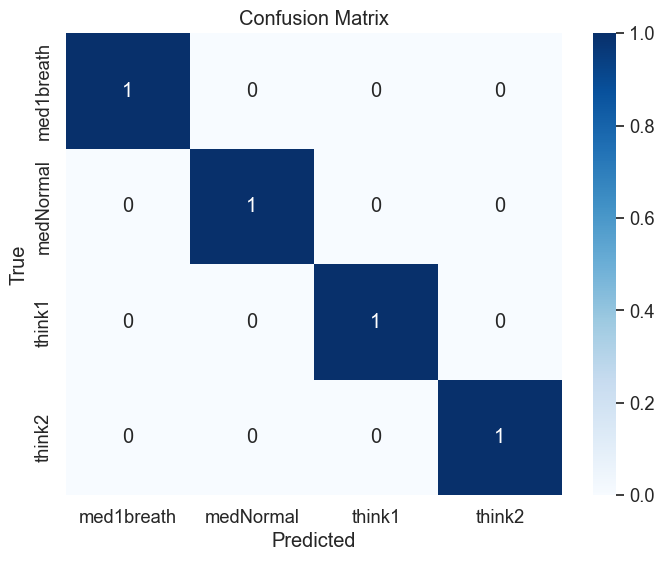

              precision    recall  f1-score   support

  med1breath       1.00      1.00      1.00         1
   medNormal       1.00      1.00      1.00         1
      think1       1.00      1.00      1.00         1
      think2       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Replace these with your actual predicted and true labels
predicted_labels = y.unique()
true_labels = y.unique()

# Get the unique class names from the labels
class_names = np.unique(true_labels)

# Compute the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# You can also print a classification report with precision, recall, and F1-score
print(classification_report(true_labels, predicted_labels, target_names=class_names))
